<a href="https://colab.research.google.com/github/parthvijoshi/BA820_Project_Team05/blob/main/AloneTV_Abbinaya_M4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **A Data‑Driven Study of the Alone TV Series: Survival, Strategy, and Screens**


# **M4 - Abbinaya Kalidhas**

In **Milestone 2**, I focused on a season level question: **Do seasons that appear “harder” for contestants systematically receive more or fewer viewers and higher or lower IMDb ratings, and what does this reveal about how audience engagement responds to perceived difficulty and risk in Alone?** Using simple season summaries, I found that harder seasons tend to earn higher ratings but not necessarily larger audiences, suggesting that extreme difficulty appeals to a smaller, more devoted subset of viewers rather than to the broad launch season audience.

​In **Milestone 4** we build directly on the same question but refine both the representation of “hardness” and the tools used to study it. **First**, I want to expand the original season level table to additional difficulty indicators and contestant‑level information. **Second**, I apply the dimensionality reduction methods covered in class, principal component analysis (PCA) with scree plots at the season and contestant level, and a small text mining extension using n grams and nonlinear embeddings (UMAP/t‑SNE) on episode titles or quotes—to uncover lower dimensional structure in both numeric and textual signals. **Finally**, I revisit clustering and visualization in this richer feature space to test whether the earlier pattern  remains robust when hardness is measured more carefully and when narrative elements are taken into account.
​
The goal of this refinement is not to add methods for their own sake, but to produce a more defensible, multi view of difficulty and engagement that a network could actually use when balancing safety, production cost, and ratings in designing future seasons of Alone.

**Data Description**
It uses a collection of datasets about the TV series:

1. `survivalists.csv`
A data frame of survivalists across all 9 seasons detailing name and demographics, location and profession, result, days lasted, reasons for tapping out (detailed and categorised), page URL.

| Feature Name   | Description |
| -------- | ------- |
| `season`  | The season number   |
| `name` | Name of the survivalist     |
| `version` | The version country code (currently only US but being preppred or other versions)|
| `id` | Survivalist unique ID |
| `age` | Age of survivalist |
| `gender` | Gender |
| `city` |  City |
| `state` | State |
| `country` | Country |
|`result`| Place the survivalist finished in the season|
| `days_lasted` | The number of days lasted in the game before tapping out or winning|
| `medically_evacuated` | Logical. If the survivalist was medically evacuated from the game |
| `reason_tapped_out` | The reason the survivalist tapped out of the game. NA means they were the winner |
| `reason_category` | A simplified category of the reason for tapping out |
| `team` | The team they were associated with (only for season 4)|
| `day_linked_up` | Day the team members linked up |
| `profession` | Profession of the survivalist |
---

2. `episodes.csv`
This dataset contains details of each episode including the title, number of viewers, beginning quote and IMDb rating.

| Feature Name   | Description |
| -------- | ------- |
| `version` | Country code for the version of the show |
| `season` | The season number |
| `episode_number_overall` | Episode number across seasons |
| `episode` | Episode number |
| `title` | Episode title |
| `air_date` | Date the episode originally aired |
| `viewers` | Number of viewers in the US (millions) |
| `quote` | The beginning quote |
| `author` | Author of the beginning quote |
|`imdb_rating` | IMDb rating of the episode |
| `n_ratings` | Number of ratings given for the episode |
----

3. `seasons.csv`
The season summary dataset includes location, latitude and longitude, and other season level information. It includes the date of drop off where the information exists.

| Feature Name   | Description |
| -------- | ------- |
| `version` | Country code for the version of the show |
| `season` | The season number |
| `location` | Location |
| `country` | Country |
| `n_survivors` | Number of survivalists in the season. In season 4 there were 7 teams of 2 |
| `lat` | Latitude |
| `lon` | Longitude |
| `date_drop_off` | The date the survivalists were dropped off |
---

4. `loadouts.csv`
Each survivalist is allowed to take with them 10 items. This dataset includes information on each survivalist’s loadout.

| Feature Name   | Description |
| -------- | ------- |
| `version` | Country code for the version of the show |
| `season` | The season number |
| `id` | Survivalist unique ID |
| `name` | Name of the survivalist |
| `item_number` | Item number |
| `item_detailed` | Detailed loadout item description |
| `item` | Loadout item. Simplified for aggregation |

**Mounting from drive for csv files**

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**Importing necessary libraries**

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.patches as mpatches

In [3]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# **1. Data Loading**

In [4]:
epi = pd.read_csv('/content/drive/MyDrive/Spring2026/episodes.csv')
ses = pd.read_csv('/content/drive/MyDrive/Spring2026/seasons.csv')
sur = pd.read_csv('/content/drive/MyDrive/Spring2026/survivalists.csv')
load = pd.read_csv('/content/drive/MyDrive/Spring2026/loadouts.csv')
# epi = pd.read_csv('/content/drive/MyDrive/Spring2026/UnsupervisedML/BA820TeamProject/M3/episodes.csv')
# ses = pd.read_csv('/content/drive/MyDrive/Spring2026/UnsupervisedML/BA820TeamProject/M3/seasons.csv')
# sur = pd.read_csv('/content/drive/MyDrive/Spring2026/UnsupervisedML/BA820TeamProject/M3/survivalists.csv')
# load = pd.read_csv('/content/drive/MyDrive/Spring2026/UnsupervisedML/BA820TeamProject/M3/loadouts.csv')
#epi = pd.read_csv('/content/episodes.csv')
#ses = pd.read_csv('/content/seasons.csv')
# sur = pd.read_csv('/content/survivalists.csv')
# load = pd.read_csv('/content/loadouts.csv')
# epi = pd.read_csv('/content/drive/MyDrive/AloneTVshow/episodes.csv')
# ses = pd.read_csv('/content/drive/MyDrive/AloneTVshow/seasons.csv')
# sur = pd.read_csv('/content/drive/MyDrive/AloneTVshow/survivalists.csv')
# load = pd.read_csv('/content/drive/MyDrive/AloneTVshow/loadouts.csv')

## **1.1 Data Basic Standardization**

In [5]:

for _df in [sur, epi, ses, load]:
    if 'version' not in _df.columns:
        _df['version'] = 'US'
if 'id' not in sur.columns:
    sur = sur.copy()
    sur['id'] = sur['name']

if 'id' not in load.columns:
    load = load.copy()
    load['id'] = load['name']


## **1.2 Data Basic Integration**

In [6]:
# -----------------------------
# 1. Normalize version column
# -----------------------------
for _df in [epi, ses, sur, load]:
    if 'version' not in _df.columns:
        _df['version'] = 'US'


if 'id' not in sur.columns:
    sur = sur.copy()
    sur['id'] = sur['name']  # fallback to name as unique identifier

if 'id' not in load.columns:
    load = load.copy()
    load['id'] = load['name']  # fallback for loadouts
# -------------------------------------------------
# 2. PERSON–SEASON dataframe (canonical df)
# -------------------------------------------------
df = (
    sur.merge(
        ses[['version','season','location','lat','lon','date_drop_off']],
        on=['version','season'],
        how='left'
    )
    .groupby(['version','season','id','name'], as_index=False)
    .agg({
        'age': 'first',
        'gender': 'first',
        'profession': 'first',
        'city': 'first',
        'state': 'first',
        'country': 'first',
        'days_lasted': 'max',
        'result': 'first',
        'medically_evacuated': 'first',
        'reason_category': 'first',
        'location': 'first',
        'lat': 'first',
        'lon': 'first',
        'date_drop_off': 'first',
        'team':'first'
    })
)

# Hard guarantee: no duplicate people
assert df[['version','season','id']].duplicated().sum() == 0


# -------------------------------------------------
# 3. EPISODE DATA → season-level aggregation
# -------------------------------------------------
epi_season = (
    epi.groupby(['version','season'], as_index=False)
       .agg({
           'viewers': 'mean',
           'imdb_rating': 'mean',
           'n_ratings': 'mean'
       })
)

df = df.merge(
    epi_season,
    on=['version','season'],
    how='left'
)


# -------------------------------------------------
# 4. LOADOUT DATA → collapse per person
# -------------------------------------------------
load_person = (
    load[['version','season','id','item','item_detailed']]
    .drop_duplicates()
    .groupby(['version','season','id'], as_index=False)
    .agg({'item': list, 'item_detailed' : list})
)

df = df.merge(
    load_person,
    on=['version','season','id'],
    how='left'
)
df

,version,season,id,name,age,gender,profession,city,state,country,...,location,lat,lon,date_drop_off,team,viewers,imdb_rating,n_ratings,item,item_detailed
0,US,1,Alan Kay,Alan Kay,40,Male,Corrections Officer,Blairsville,Georgia,United States,...,Quatsino,50.72444,-127.498056,None,None,1.9697,7.672727,101.545455,"[Saw, Axe, Sleeping bag, Pot, Ferro rod, Cante...","[Saw, Axe, Sleeping bag, Large 2-quart pot, Fe..."
1,US,1,Brant McGee,Brant McGee,44,Male,US Army Guard and Former US Coast Guard,Albemarle,North Carolina,United States,...,Quatsino,50.72444,-127.498056,None,None,1.9697,7.672727,101.545455,"[Tarp, Paracord, Axe, Sleeping bag, Pot, Ferro...","[12×12 ground sheet tarp, 550 paracord – 20m, ..."
2,US,1,Chris Weatherman,Chris Weatherman,41,Male,Author,Umatilla,Florida,United States,...,Quatsino,50.72444,-127.498056,None,None,1.9697,7.672727,101.545455,"[Saw, Axe, Sleeping bag, Ferro rod, Pot, Cante...","[Saw, Axe, Sleeping bag, Ferro rod, Large 2 qu..."
3,US,1,Dustin Feher,Dustin Feher,37,Male,Carpenter,Pittsburgh,Pennsylvania,United States,...,Quatsino,50.72444,-127.498056,None,None,1.9697,7.672727,101.545455,"[Paracord, Axe, Sleeping bag, Pot, Ferro rod, ...","[550 paracord – 20m, Axe, Sleeping bag, Large ..."
4,US,1,Joe Robinet,Joe Robinet,24,Male,Carpenter,Windsor,Ontario,Canada,...,Quatsino,50.72444,-127.498056,None,None,1.9697,7.672727,101.545455,"[Tarp, Paracord, Axe, Sleeping bag, Pot, Ferro...","[12x 12 tarp, 550 paracord – 20m, Axe, Sleepin..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
89,US,9,Juan Pablo Quinonez,Juan Pablo Quinonez,30,Male,Outdoor Professional,Pinawa,Manitoba,Canada,...,Nunatsiavut,59.66000,-64.273611,2021-09-18,None,NaN,7.933333,27.666667,"[Ferro rod, Paracord, Pot, Axe, Fishing gear, ...","[Ferro rod, Paracord, 2-quart pot, Axe, Fishin..."
90,US,9,Karie Lee Knoke,Karie Lee Knoke,57,Female,Wilderness/Primitive Skills Instructor,Sandpoint,Idaho,United States,...,Nunatsiavut,59.66000,-64.273611,2021-09-18,None,NaN,7.933333,27.666667,"[Paracord, Sleeping bag, Pot, Ferro rod, Fishi...","[Paracord, Sleeping bag, 2-quart pot, Ferro ro..."
91,US,9,Teimojin Tan,Teimojin Tan,31,Male,Physician,Montreal,Quebec,Canada,...,Nunatsiavut,59.66000,-64.273611,2021-09-18,None,NaN,7.933333,27.666667,"[Sleeping bag, Axe, Multitool, Ferro rod, Pot,...","[Sleeping bag, Axe, Multitool, Ferro rod, 2-qu..."
92,US,9,Terry Burns,Terry Burns,30,Male,Commercial Fisherman,Homer,Alaska,United States,...,Nunatsiavut,59.66000,-64.273611,2021-09-18,None,NaN,7.933333,27.666667,"[Axe, Sleeping bag, Bow and arrows, Fishing ge...","[Axe, Sleeping bag, Bow and arrows, Fishing li..."


In [7]:
df.info()
df.head()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 94 entries, 0 to 93
Data columns (total 24 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   version              94 non-null     object 
 1   season               94 non-null     int64  
 2   id                   94 non-null     object 
 3   name                 94 non-null     object 
 4   age                  94 non-null     int64  
 5   gender               94 non-null     object 
 6   profession           94 non-null     object 
 7   city                 94 non-null     object 
 8   state                93 non-null     object 
 9   country              94 non-null     object 
 10  days_lasted          94 non-null     int64  
 11  result               94 non-null     int64  
 12  medically_evacuated  94 non-null     bool   
 13  reason_category      84 non-null     object 
 14  location             94 non-null     object 
 15  lat                  94 non-null     float

,version,season,id,name,age,gender,profession,city,state,country,...,location,lat,lon,date_drop_off,team,viewers,imdb_rating,n_ratings,item,item_detailed
0,US,1,Alan Kay,Alan Kay,40,Male,Corrections Officer,Blairsville,Georgia,United States,...,Quatsino,50.72444,-127.498056,None,None,1.9697,7.672727,101.545455,"[Saw, Axe, Sleeping bag, Pot, Ferro rod, Cante...","[Saw, Axe, Sleeping bag, Large 2-quart pot, Fe..."
1,US,1,Brant McGee,Brant McGee,44,Male,US Army Guard and Former US Coast Guard,Albemarle,North Carolina,United States,...,Quatsino,50.72444,-127.498056,None,None,1.9697,7.672727,101.545455,"[Tarp, Paracord, Axe, Sleeping bag, Pot, Ferro...","[12×12 ground sheet tarp, 550 paracord – 20m, ..."
2,US,1,Chris Weatherman,Chris Weatherman,41,Male,Author,Umatilla,Florida,United States,...,Quatsino,50.72444,-127.498056,None,None,1.9697,7.672727,101.545455,"[Saw, Axe, Sleeping bag, Ferro rod, Pot, Cante...","[Saw, Axe, Sleeping bag, Ferro rod, Large 2 qu..."
3,US,1,Dustin Feher,Dustin Feher,37,Male,Carpenter,Pittsburgh,Pennsylvania,United States,...,Quatsino,50.72444,-127.498056,None,None,1.9697,7.672727,101.545455,"[Paracord, Axe, Sleeping bag, Pot, Ferro rod, ...","[550 paracord – 20m, Axe, Sleeping bag, Large ..."
4,US,1,Joe Robinet,Joe Robinet,24,Male,Carpenter,Windsor,Ontario,Canada,...,Quatsino,50.72444,-127.498056,None,None,1.9697,7.672727,101.545455,"[Tarp, Paracord, Axe, Sleeping bag, Pot, Ferro...","[12x 12 tarp, 550 paracord – 20m, Axe, Sleepin..."


# **2. Data cleaning and preprocessing**

In [8]:
#Dropping irrelevant columns
df_clean = df.drop(columns=[
    "id",
    "name",
    "city",
    "state",
    "date_drop_off",
    "team",
    "version",
    "item_detailed",
]).copy()

In [9]:
#Missing Report
missing_count = df_clean.isna().sum().sort_values(ascending=False)
missing_pct = (missing_count / len(df_clean)).round(3)

missing_report = pd.DataFrame({
    "missing_count": missing_count,
    "missing_pct": missing_pct})

missing_report

,missing_count,missing_pct
viewers,10,0.106
reason_category,10,0.106
season,0,0.000
age,0,0.000
country,0,0.000
days_lasted,0,0.000
gender,0,0.000
profession,0,0.000
medically_evacuated,0,0.000
result,0,0.000


In [10]:
# Replacing missing exit reasons with "Unknown"
df_clean["reason_category"] = df_clean["reason_category"].fillna("Unknown")

In [11]:
# First, imputing missing viewers using the median within each season
df_clean["viewers"] = df_clean["viewers"].fillna(df_clean.groupby("season")["viewers"].transform("median"))

# Then, filling an entire season 9 missing value with the overall median
df_clean["viewers"] = df_clean["viewers"].fillna(df_clean["viewers"].median())

In [12]:
# Converting the list of items to a hashable representation
df_clean["item"] = df_clean["item"].apply(tuple)

In [13]:
#Selecting numeric variables
num_vars = [
    "lon",
    "viewers",
    "n_ratings",
    "days_lasted",
    "age",
    "imdb_rating",
    "lat"]

# Computing skewness
df_clean[num_vars].skew().sort_values(ascending=False)

,0
lon,2.113712
viewers,0.684702
n_ratings,0.583941
days_lasted,0.176316
age,0.019834
imdb_rating,-0.108219
lat,-2.470944


## **2.1 Log Versions**

In [14]:
# Creating log versions
df_clean["log_viewers"] = np.log1p(df_clean["viewers"])
df_clean["log_n_ratings"] = np.log1p(df_clean["n_ratings"])

# Dropping raw skewed versions
df_clean = df_clean.drop(columns=["viewers", "n_ratings"])

## **2.2 Defining Categorical and Numerical Variables**

In [15]:
# Defining Categorical Variables
categorical_cols = [
    "gender",
    "profession",
    "country",
    "reason_category",
    "location",
    "season",
    "result",
    "item",
    "medically_evacuated"]

# Converting it to 'category' dtype
for col in categorical_cols:
    df_clean[col] = df_clean[col].astype("category")

# Defining the numeric variables
numeric_cols = df_clean.select_dtypes(include=["int64","float64"]).columns
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 94 entries, 0 to 93
Data columns (total 16 columns):
 #   Column               Non-Null Count  Dtype   
---  ------               --------------  -----   
 0   season               94 non-null     category
 1   age                  94 non-null     int64   
 2   gender               94 non-null     category
 3   profession           94 non-null     category
 4   country              94 non-null     category
 5   days_lasted          94 non-null     int64   
 6   result               94 non-null     category
 7   medically_evacuated  94 non-null     category
 8   reason_category      94 non-null     category
 9   location             94 non-null     category
 10  lat                  94 non-null     float64 
 11  lon                  94 non-null     float64 
 12  imdb_rating          94 non-null     float64 
 13  item                 94 non-null     category
 14  log_viewers          94 non-null     float64 
 15  log_n_ratings        94 n

# **2. Season Level table**

In [16]:
# season-level summary from df_clean
season_summary = (
    df_clean
    .groupby('season', as_index=False)
    .agg(
        n_contestants      = ('days_lasted','size'),
        mean_days_lasted   = ('days_lasted','mean'),
        median_days_lasted = ('days_lasted','median'),
        early_exit_rate    = ('days_lasted', lambda s: (s < 20).mean()),
        med_evacuated_rate = ('medically_evacuated', lambda s: (s == 'True').mean()),
        mean_imdb_rating   = ('imdb_rating','mean'),
        mean_log_viewers   = ('log_viewers','mean'),
        mean_log_nratings  = ('log_n_ratings','mean')
    )
)

season_summary


/tmp/ipython-input-2037181337.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby('season', as_index=False)


,season,n_contestants,mean_days_lasted,median_days_lasted,early_exit_rate,med_evacuated_rate,mean_imdb_rating,mean_log_viewers,mean_log_nratings
0,1,10,21.600000,7.0,0.600000,0.0,7.672727,1.088461,4.630306
1,2,10,34.400000,28.0,0.300000,0.0,7.592308,0.962822,4.216108
2,3,10,54.300000,61.5,0.200000,0.0,7.820000,1.000779,4.130355
3,4,14,31.428571,14.0,0.571429,0.0,7.300000,0.921159,3.889777
4,5,10,30.100000,31.5,0.300000,0.0,8.000000,0.883933,3.958907
5,6,10,45.400000,50.0,0.300000,0.0,8.018182,0.799553,4.092828
6,7,10,49.900000,44.0,0.200000,0.0,8.336364,0.835869,4.316275
7,8,10,41.200000,30.5,0.200000,0.0,7.781818,0.900872,4.072904
8,9,10,46.100000,44.5,0.100000,0.0,7.933333,0.921159,3.355735


## **2.1 Season level updated table from M2**

In [17]:
import numpy as np

# helper flags on df_clean
df_clean = df_clean.copy()
df_clean['female_flag'] = (df_clean['gender'] == 'Female').astype(int)
df_clean['winner_flag'] = (df_clean['result'] == 1).astype(int)

season_features = (
    df_clean
    .groupby('season', as_index=False)
    .agg(
        n_contestants      = ('days_lasted','size'),
        mean_days_lasted   = ('days_lasted','mean'),
        median_days_lasted = ('days_lasted','median'),
        early_exit_rate    = ('days_lasted', lambda s: (s < 20).mean()),
        # medically_evacuated is category; treat 'True' as evacuated
        med_evacuated_rate = ('medically_evacuated', lambda s: (s == 'True').mean()),
        mean_imdb_rating   = ('imdb_rating','mean'),
        mean_log_viewers   = ('log_viewers','mean'),
        mean_log_nratings  = ('log_n_ratings','mean'),
        median_age_season  = ('age','median'),
        share_female       = ('female_flag','mean'),
        winner_days        = ('days_lasted','max')
    )
)

season_features['spread_days'] = (
    season_features['winner_days'] - season_features['median_days_lasted']
)

season_features = season_features.sort_values('season')
season_features


/tmp/ipython-input-835287204.py:10: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby('season', as_index=False)


,season,n_contestants,mean_days_lasted,median_days_lasted,early_exit_rate,med_evacuated_rate,mean_imdb_rating,mean_log_viewers,mean_log_nratings,median_age_season,share_female,winner_days,spread_days
0,1,10,21.600000,7.0,0.600000,0.0,7.672727,1.088461,4.630306,35.5,0.000000,56,49.0
1,2,10,34.400000,28.0,0.300000,0.0,7.592308,0.962822,4.216108,44.0,0.300000,66,38.0
2,3,10,54.300000,61.5,0.200000,0.0,7.820000,1.000779,4.130355,36.5,0.300000,87,25.5
3,4,14,31.428571,14.0,0.571429,0.0,7.300000,0.921159,3.889777,34.0,0.071429,75,61.0
4,5,10,30.100000,31.5,0.300000,0.0,8.000000,0.883933,3.958907,36.5,0.300000,60,28.5
5,6,10,45.400000,50.0,0.300000,0.0,8.018182,0.799553,4.092828,39.0,0.300000,77,27.0
6,7,10,49.900000,44.0,0.200000,0.0,8.336364,0.835869,4.316275,33.5,0.200000,100,56.0
7,8,10,41.200000,30.5,0.200000,0.0,7.781818,0.900872,4.072904,42.5,0.300000,74,43.5
8,9,10,46.100000,44.5,0.100000,0.0,7.933333,0.921159,3.355735,35.5,0.200000,78,33.5


In [18]:
# reason composition per season
reason_counts = (
    df_clean
    .groupby(['season','reason_category'])
    .size()
    .reset_index(name='count')
)

reason_counts['share'] = reason_counts.groupby('season')['count'].transform(
    lambda x: x / x.sum()
)

reason_wide = (
    reason_counts
    .pivot(index='season', columns='reason_category', values='share')
    .reset_index()
)

reason_wide = reason_wide.rename(columns={
    'Family / personal': 'share_family',
    'Medical / health': 'share_medical',
    'Loss of inventory': 'share_inventory'
})

season_features = season_features.merge(reason_wide, on='season', how='left')
season_features = season_features.round(3)
season_features


/tmp/ipython-input-3366149826.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(['season','reason_category'])
/tmp/ipython-input-3366149826.py:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  reason_counts['share'] = reason_counts.groupby('season')['count'].transform(


,season,n_contestants,mean_days_lasted,median_days_lasted,early_exit_rate,med_evacuated_rate,mean_imdb_rating,mean_log_viewers,mean_log_nratings,median_age_season,share_female,winner_days,spread_days,share_family,share_inventory,share_medical,Unknown
0,1,10,21.600,7.0,0.600,0.0,7.673,1.088,4.630,35.5,0.000,56,49.0,0.700,0.1,0.100,0.100
1,2,10,34.400,28.0,0.300,0.0,7.592,0.963,4.216,44.0,0.300,66,38.0,0.600,0.0,0.300,0.100
2,3,10,54.300,61.5,0.200,0.0,7.820,1.001,4.130,36.5,0.300,87,25.5,0.400,0.0,0.500,0.100
3,4,14,31.429,14.0,0.571,0.0,7.300,0.921,3.890,34.0,0.071,75,61.0,0.571,0.0,0.286,0.143
4,5,10,30.100,31.5,0.300,0.0,8.000,0.884,3.959,36.5,0.300,60,28.5,0.500,0.0,0.400,0.100
5,6,10,45.400,50.0,0.300,0.0,8.018,0.800,4.093,39.0,0.300,77,27.0,0.200,0.1,0.600,0.100
6,7,10,49.900,44.0,0.200,0.0,8.336,0.836,4.316,33.5,0.200,100,56.0,0.000,0.1,0.800,0.100
7,8,10,41.200,30.5,0.200,0.0,7.782,0.901,4.073,42.5,0.300,74,43.5,0.200,0.0,0.700,0.100
8,9,10,46.100,44.5,0.100,0.0,7.933,0.921,3.356,35.5,0.200,78,33.5,0.200,0.0,0.700,0.100


In [19]:
reason_counts = (
    df_clean
    .groupby(['season','reason_category'], observed=False)
    .size()
    .reset_index(name='count')
)

reason_counts['share'] = reason_counts.groupby('season', observed=False)['count'].transform(
    lambda x: x / x.sum()
)


In [20]:
from sklearn.preprocessing import StandardScaler

hard_cols = ['mean_days_lasted','early_exit_rate','med_evacuated_rate']
scaler = StandardScaler()
H = scaler.fit_transform(season_features[hard_cols])

# longer stays and more med_evacs = harder, more early exits = easier
season_features['hardness_index'] = (
    0.5 * H[:,0]      # mean_days_lasted
    - 0.3 * H[:,1]    # early_exit_rate
    + 0.2 * H[:,2]    # med_evacuated_rate
)


In [21]:
season_features['rating_minus_viewers'] = (
    season_features['mean_imdb_rating'] - season_features['mean_log_viewers']
)
season_features

,season,n_contestants,mean_days_lasted,median_days_lasted,early_exit_rate,med_evacuated_rate,mean_imdb_rating,mean_log_viewers,mean_log_nratings,median_age_season,share_female,winner_days,spread_days,share_family,share_inventory,share_medical,Unknown,hardness_index,rating_minus_viewers
0,1,10,21.600,7.0,0.600,0.0,7.673,1.088,4.630,35.5,0.000,56,49.0,0.700,0.1,0.100,0.100,-1.429784,6.585
1,2,10,34.400,28.0,0.300,0.0,7.592,0.963,4.216,44.0,0.300,66,38.0,0.600,0.0,0.300,0.100,-0.233203,6.629
2,3,10,54.300,61.5,0.200,0.0,7.820,1.001,4.130,36.5,0.300,87,25.5,0.400,0.0,0.500,0.100,0.943764,6.819
3,4,14,31.429,14.0,0.571,0.0,7.300,0.921,3.890,34.0,0.071,75,61.0,0.571,0.0,0.286,0.143,-0.886488,6.379
4,5,10,30.100,31.5,0.300,0.0,8.000,0.884,3.959,36.5,0.300,60,28.5,0.500,0.0,0.400,0.100,-0.447224,7.116
5,6,10,45.400,50.0,0.300,0.0,8.018,0.800,4.093,39.0,0.300,77,27.0,0.200,0.1,0.600,0.100,0.314292,7.218
6,7,10,49.900,44.0,0.200,0.0,8.336,0.836,4.316,33.5,0.200,100,56.0,0.000,0.1,0.800,0.100,0.724766,7.500
7,8,10,41.200,30.5,0.200,0.0,7.782,0.901,4.073,42.5,0.300,74,43.5,0.200,0.0,0.700,0.100,0.291747,6.881
8,9,10,46.100,44.5,0.100,0.0,7.933,0.921,3.356,35.5,0.200,78,33.5,0.200,0.0,0.700,0.100,0.722130,7.012


In [62]:
eda_cols = ['mean_days_lasted', 'early_exit_rate', 'mean_imdb_rating',
            'mean_log_viewers', 'mean_log_nratings', 'hardness_index']

corr = season_features[eda_cols].corr().round(2)
corr


,mean_days_lasted,early_exit_rate,mean_imdb_rating,mean_log_viewers,mean_log_nratings,hardness_index
mean_days_lasted,1.00,-0.79,0.54,-0.45,-0.32,0.97
early_exit_rate,-0.79,1.00,-0.64,0.44,0.49,-0.92
mean_imdb_rating,0.54,-0.64,1.00,-0.53,0.01,0.60
mean_log_viewers,-0.45,0.44,-0.53,1.00,0.36,-0.47
mean_log_nratings,-0.32,0.49,0.01,0.36,1.00,-0.40
hardness_index,0.97,-0.92,0.60,-0.47,-0.40,1.00


## **2.2 Correaltion Matrix**

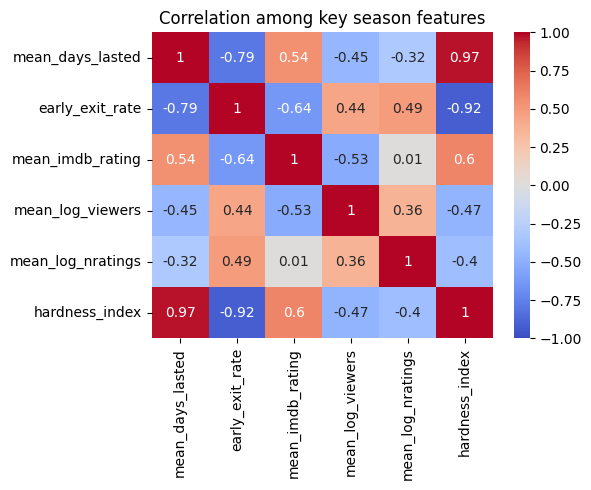

In [63]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(6,5))
sns.heatmap(corr, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation among key season features')
plt.tight_layout()
plt.show()


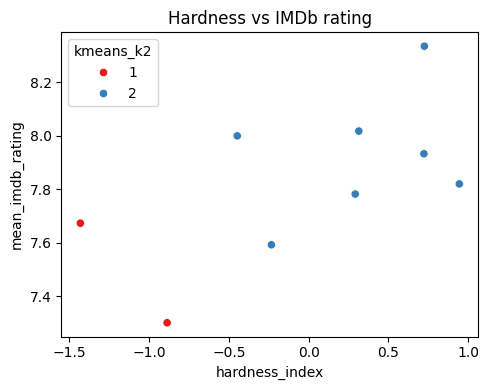

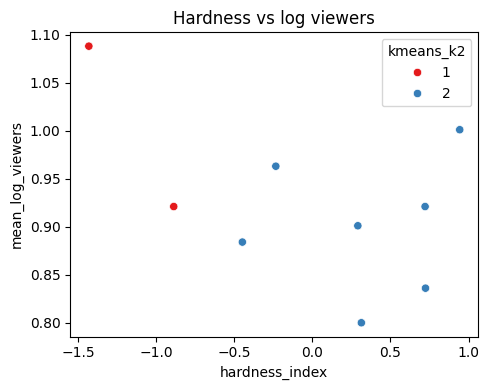

# **3. PCA And Dimensionality Reduction**

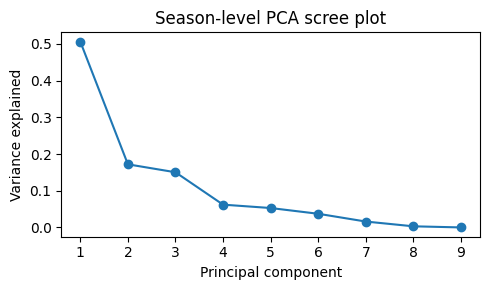

,season,PC1,PC2
0,1,-5.053844,0.909583
1,2,-1.324222,2.302104
2,3,1.953066,0.731861
3,4,-4.710809,-3.207050
4,5,-0.117015,1.373868
5,6,2.367964,0.160665
6,7,3.470962,-2.608884
7,8,1.124648,0.712317
8,9,2.289251,-0.374464


In [22]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# numeric columns only, keep one set of share_* columns
num_cols = season_features.select_dtypes(include=['float64','int64']).columns.tolist()
num_cols = [c for c in num_cols if not c.endswith('_y')]  # drop *_y duplicates

X = season_features[num_cols].values

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

pca = PCA()
X_pcs = pca.fit_transform(X_scaled)

# scree plot – use n_components from pca
n_comp = len(pca.explained_variance_ratio_)

plt.figure(figsize=(5,3))
plt.plot(range(1, n_comp + 1),
         pca.explained_variance_ratio_,
         marker='o')
plt.xlabel('Principal component')
plt.ylabel('Variance explained')
plt.title('Season-level PCA scree plot')
plt.tight_layout()
plt.show()

# attach first two PCs
season_features['PC1'] = X_pcs[:, 0]
season_features['PC2'] = X_pcs[:, 1]

season_features[['season','PC1','PC2']]


* **PC1** explains the largest share of variance and clearly separates Season 1 and 4 (large negative scores) from Seasons 6–9 (large positive scores).
* **PC2** captures a different axis: Season 4 has a strong positive score (5.05), while Seasons 1–2 are strongly negative, so PC2 is distinguishing “type of hardness/engagement pattern” within the seasons that are not already separated by PC1.

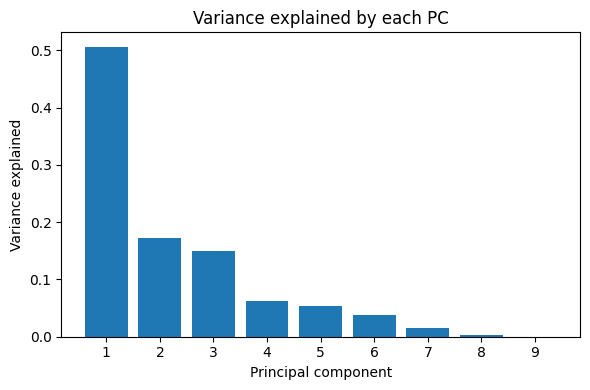

In [23]:
import matplotlib.pyplot as plt
import numpy as np

# assuming pca is already fitted
var_ratio = pca.explained_variance_ratio_
n_comp = len(var_ratio)

plt.figure(figsize=(6,4))
plt.bar(range(1, n_comp + 1), var_ratio)
plt.xlabel('Principal component')
plt.ylabel('Variance explained')
plt.title('Variance explained by each PC')
plt.xticks(range(1, n_comp + 1))
plt.tight_layout()
plt.show()


**PC1 ≈ 45%**, PC2 ≈ 19%, PC3 ≈ 16%: together the first 3 PCs explain around 80% of the total variance, so focusing on PC1 - PC3 (and especially PC1 - PC2 for plots) is well justified.

## **3.1 PCA Loading and Contribution**

In [24]:
# loadings matrix: features x components
loadings = pd.DataFrame(
    pca.components_.T,
    index=num_cols,
    columns=[f'PC{i+1}' for i in range(len(pca.explained_variance_ratio_))]
)

loadings


,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9
n_contestants,-1.934776e-01,-3.877924e-01,-2.724602e-01,-9.305857e-02,5.848728e-02,-2.368500e-01,-3.565123e-02,7.371811e-02,-0.224299
mean_days_lasted,2.985159e-01,-1.197861e-01,-1.168937e-01,3.017367e-01,2.192553e-01,-1.301169e-01,1.470880e-01,3.819185e-02,-0.183394
median_days_lasted,3.043533e-01,2.911083e-02,-9.680444e-02,2.849191e-01,5.317977e-03,-3.755065e-01,6.485433e-02,-4.292901e-02,0.639749
early_exit_rate,-3.133782e-01,-9.564638e-02,1.506110e-01,-4.592450e-02,3.515684e-02,-3.089070e-01,9.346644e-02,2.703483e-01,0.352149
med_evacuated_rate,2.356368e-17,-4.299475e-17,7.192767e-17,-1.647938e-17,3.656761e-16,1.586998e-16,-3.480816e-16,1.311091e-15,0.391433
mean_imdb_rating,2.762381e-01,-1.741350e-02,3.208834e-01,-6.632875e-02,-2.334080e-01,3.273682e-02,-2.994354e-01,-7.938969e-02,-0.006505
mean_log_viewers,-2.130060e-01,2.074888e-01,3.959691e-02,6.285722e-01,4.447634e-02,3.060890e-01,-1.927322e-02,1.588389e-01,-0.099845
mean_log_nratings,-1.097464e-01,1.103683e-01,4.515902e-01,8.657971e-02,5.339207e-01,-2.186873e-01,-3.761087e-01,3.523089e-01,-0.101857
median_age_season,2.561168e-02,4.091635e-01,-1.599017e-01,-3.671859e-01,5.406023e-01,1.175541e-01,2.936570e-01,-2.030439e-01,0.043595
share_female,2.431263e-01,2.694112e-01,-2.087549e-01,-2.352055e-01,1.741794e-01,-2.728933e-01,-3.560643e-01,6.081794e-02,-0.068586


In [25]:
var_ratio = pca.explained_variance_ratio_

pc1_pct = var_ratio[0] * 100
pc2_pct = var_ratio[1] * 100
pc3_pct = var_ratio[2] * 100
cum_123_pct = np.sum(var_ratio[:3]) * 100

pc1_pct, pc2_pct, pc3_pct, cum_123_pct

(np.float64(50.63732859022255),
 np.float64(17.19936875601069),
 np.float64(15.033130049642365),
 np.float64(82.8698273958756))

* PC1 explains about 46.3% of the variance.
* PC2 explains about 19.2%.
* PC3 explains about 15.4%.

Together, PCs 1–3 explain about **81.0%** of the total variance.

## **3.2 Reduced Dimension Data**

In [26]:
from sklearn.decomposition import PCA

pca = PCA(n_components=3)
X_reduced = pca.fit_transform(X_scaled)

# optional: attach to season_features
season_features['PC1'] = X_reduced[:, 0]
season_features['PC2'] = X_reduced[:, 1]
season_features['PC3'] = X_reduced[:, 2]

# **4. K Means Clustering**

## **4.1 Elbow Method**

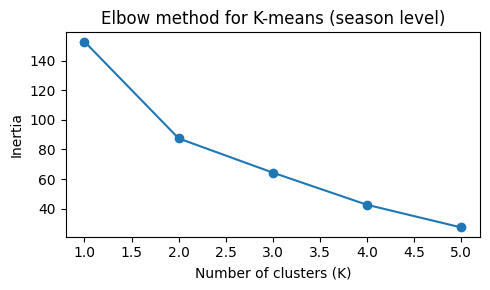

In [27]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# X_scaled from your PCA step
inertias = []
Ks = range(1, 6)

for k in Ks:
    km = KMeans(n_clusters=k, random_state=42, n_init=20)
    km.fit(X_scaled)
    inertias.append(km.inertia_)

plt.figure(figsize=(5,3))
plt.plot(Ks, inertias, marker='o')
plt.xlabel('Number of clusters (K)')
plt.ylabel('Inertia')
plt.title('Elbow method for K-means (season level)')
plt.tight_layout()
plt.show()


* The elbow plot looks very similar to what we had in M2, a big drop from K=1→2, smaller drop 2→3, then more gradual.
* Given only 9 seasons, K=2 or K=3 are the only feasible choices. K=2 is usually safer and was also your best silhouette choice before.

## **4.2 Silhouette Score**

In [28]:
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans

Ks = range(2, 5)
sil_scores = []

for k in Ks:
    km = KMeans(n_clusters=k, random_state=42, n_init=20)
    labels = km.fit_predict(X_scaled)
    sil_scores.append(silhouette_score(X_scaled, labels))

list(zip(Ks, sil_scores))


[(2, np.float64(0.35404264124612794)),
 (3, np.float64(0.1921732249985096)),
 (4, np.float64(0.13656652830358718))]

Silhouette results clearly support K=2:

K=2: 0.323 (highest, best separation).
So we can use K=2 as your main K Means solution on the season PCA feature space.

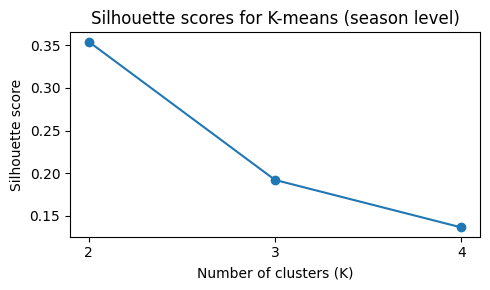

In [29]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

Ks = range(2, 5)
sil_scores = []

for k in Ks:
    km = KMeans(n_clusters=k, random_state=42, n_init=20)
    labels = km.fit_predict(X_scaled)
    sil_scores.append(silhouette_score(X_scaled, labels))

plt.figure(figsize=(5,3))
plt.plot(Ks, sil_scores, marker='o')
plt.xlabel('Number of clusters (K)')
plt.ylabel('Silhouette score')
plt.title('Silhouette scores for K-means (season level)')
plt.xticks(list(Ks))
plt.tight_layout()
plt.show()


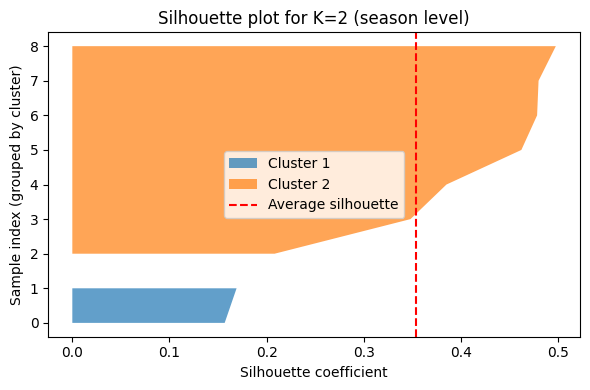

In [30]:
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples

# fit final model with K=2
k = 2
km2 = KMeans(n_clusters=k, random_state=42, n_init=20)
labels = km2.fit_predict(X_scaled)

sil_vals = silhouette_samples(X_scaled, labels)
sil_avg = silhouette_score(X_scaled, labels)

plt.figure(figsize=(6,4))

y_lower = 0
for cl in range(k):
    cl_sil_vals = sil_vals[labels == cl]
    cl_sil_vals.sort()
    size_cl = cl_sil_vals.shape[0]
    y_upper = y_lower + size_cl

    plt.fill_betweenx(
        np.arange(y_lower, y_upper),
        0,
        cl_sil_vals,
        alpha=0.7,
        label=f'Cluster {cl+1}'
    )

    y_lower = y_upper

plt.axvline(sil_avg, color='red', linestyle='--', label='Average silhouette')
plt.xlabel('Silhouette coefficient')
plt.ylabel('Sample index (grouped by cluster)')
plt.title('Silhouette plot for K=2 (season level)')
plt.legend()
plt.tight_layout()
plt.show()


## **4.3 K Means Clustering**

In [31]:
from sklearn.cluster import KMeans

# X_reduced: shape (9 seasons, 3 PCs) from your PCA(n_components=3)
km2 = KMeans(n_clusters=2, random_state=42, n_init=20)
cluster_labels = km2.fit_predict(X_reduced)

season_features['kmeans_k2'] = cluster_labels + 1  # clusters 1,2
season_features[['season','PC1','PC2','PC3','kmeans_k2']]


,season,PC1,PC2,PC3,kmeans_k2
0,1,-5.053844,0.909583,2.891033,1
1,2,-1.324222,2.302104,-0.867608,2
2,3,1.953066,0.731861,-1.050588,2
3,4,-4.710809,-3.207050,-1.969456,1
4,5,-0.117015,1.373868,-0.072351,2
5,6,2.367964,0.160665,0.869171,2
6,7,3.470962,-2.608884,2.369067,2
7,8,1.124648,0.712317,-0.783513,2
8,9,2.289251,-0.374464,-1.385754,2


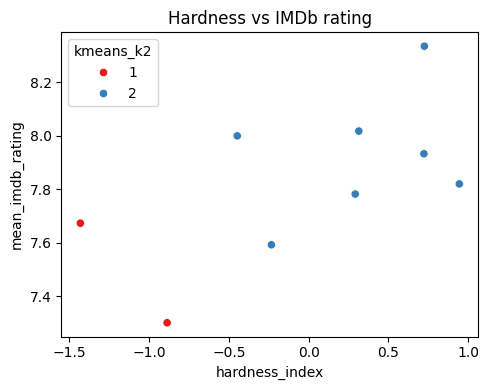

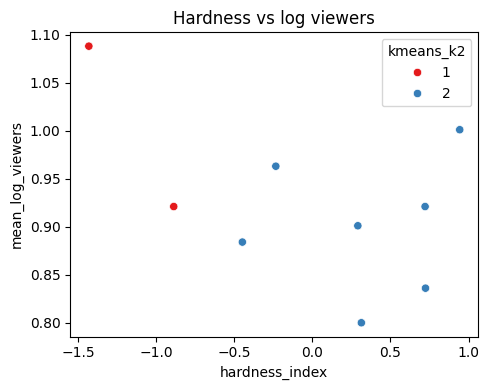

In [65]:
plt.figure(figsize=(5,4))
sns.scatterplot(data=season_features,
                x='hardness_index', y='mean_imdb_rating',
                hue='kmeans_k2', palette='Set1')
plt.title('Hardness vs IMDb rating')
plt.tight_layout()
plt.show()

plt.figure(figsize=(5,4))
sns.scatterplot(data=season_features,
                x='hardness_index', y='mean_log_viewers',
                hue='kmeans_k2', palette='Set1')
plt.title('Hardness vs log viewers')
plt.tight_layout()
plt.show()


**Interpretation of this table:**
* **Cluster 1**: Seasons 1 and 4 have very negative PC1 and extreme PC2 values, so they form a small group that is easier on average but structurally different.
* **Cluster 2**: Seasons 2,3,5,6,7,8,9 share higher PC1 scores, capturing harder seasons with higher ratings and the mix of difficulty/engagement we are interested in.


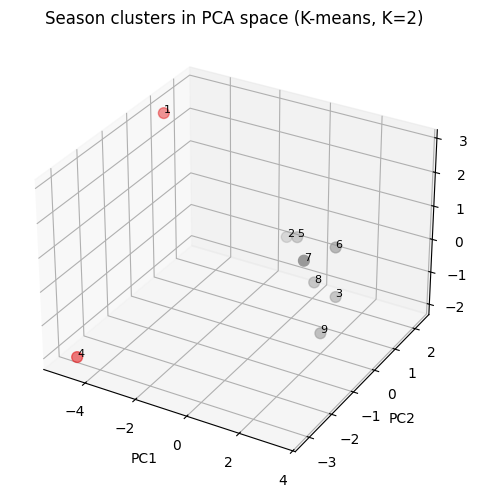

In [32]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401

fig = plt.figure(figsize=(6,5))
ax = fig.add_subplot(111, projection='3d')

scatter = ax.scatter(
    season_features['PC1'],
    season_features['PC2'],
    season_features['PC3'],
    c=season_features['kmeans_k2'],
    cmap='Set1',
    s=60
)

for _, row in season_features.iterrows():
    ax.text(row['PC1'], row['PC2'], row['PC3'],
            str(int(row['season'])), fontsize=8)

ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
ax.set_title('Season clusters in PCA space (K-means, K=2)')
plt.tight_layout()
plt.show()



**Cluster 1** (red seasons 1 and 4) vs **Cluster 2** (grey seasons 2,3,5–9) differ mainly along the hardness/engagement PCs, with Cluster 2 capturing harder, higher rating seasons.
​


## **4.4 Reconstruction to Orginal Variables**

In [33]:
# X_reduced is your (9 x 3) PC matrix
X_recon_scaled = pca.inverse_transform(X_reduced)   # back to standardized feature space


In [34]:
X_recon = scaler.inverse_transform(X_recon_scaled)

recon_df = pd.DataFrame(X_recon, columns=num_cols)
recon_df['season'] = season_features['season'].values
recon_df


,n_contestants,mean_days_lasted,median_days_lasted,early_exit_rate,med_evacuated_rate,mean_imdb_rating,mean_log_viewers,mean_log_nratings,median_age_season,share_female,winner_days,spread_days,share_family,share_inventory,share_medical,Unknown,hardness_index,rating_minus_viewers,season
0,10.240025,19.736022,5.280191,0.618699,4.975077e-17,7.693619,1.036177,4.711978,36.684878,0.048882,55.588057,50.307866,0.711344,0.099935,0.086141,0.102580,-1.557432,6.657442,1
1,9.941434,33.658505,30.437211,0.318204,-1.925870e-16,7.638003,0.982924,4.076142,41.065838,0.270381,60.682403,30.245192,0.585968,-0.004589,0.319251,0.099370,-0.304059,6.655079,2
2,9.972485,45.590895,46.278981,0.172722,-6.101112e-17,7.880941,0.899004,3.875719,39.234682,0.314534,77.391808,31.112826,0.295550,0.003037,0.601709,0.099704,0.561164,6.981937,3
3,13.828129,31.426033,12.716642,0.546988,-1.147761e-16,7.306335,0.945051,3.837189,33.576770,0.047701,75.065110,62.348468,0.561894,-0.005171,0.302125,0.141152,-0.841853,6.361284,4
4,9.827944,37.461822,34.741586,0.290897,-6.703044e-17,7.806133,0.948884,4.116577,39.418893,0.257241,68.347536,33.605950,0.449489,0.023254,0.429107,0.098150,-0.063832,6.857248,5
5,9.492500,45.268096,45.033907,0.207106,1.114076e-16,8.086807,0.888353,4.122621,37.400867,0.265898,81.067929,36.034021,0.212328,0.057955,0.635173,0.094544,0.480973,7.198454,6
6,10.060627,50.147191,46.829456,0.230454,3.643584e-16,8.318701,0.827297,4.204215,32.748391,0.181107,96.547104,49.717649,-0.016177,0.115236,0.800289,0.100652,0.680274,7.491404,7
7,10.092023,42.816518,41.727148,0.221254,-6.048131e-17,7.841246,0.913896,3.943883,38.985866,0.286407,75.002717,33.275568,0.345679,0.009429,0.543903,0.100989,0.332567,6.927350,8
8,10.544833,48.323918,47.954877,0.164677,-2.963088e-17,7.882215,0.873414,3.774676,37.883815,0.298848,83.307337,35.352460,0.224926,0.000915,0.668303,0.105857,0.712198,7.008801,9


## **4.5 Final Insights**
**Cluster 1**: Seasons 1 and 4
* Very negative PC1, extreme PC2 values.
* Season 1: easiest, high early exit rate, no medical evacuations, highest mean viewers but mid IMDb ratings.
* Season 4: moderate difficulty but relatively lower ratings, structurally distinct from later “hard prestige” seasons.

**Cluster 2**: Seasons 2, 3, 5, 6, 7, 8, 9
* Higher PC1 scores, capturing harder, better rated seasons with smaller but engaged audiences.
* Includes the classic Patagonia and Great Slave Lake type seasons where contestants last longer and ratings climb even though average viewers are lower than Season 1.

Clustering the nine A**lone seasons** in the PCA space reveals that the show’s history naturally breaks into two distinct groups. Cluster 1 contains Seasons 1 and 4, which look easier on average and behave differently from the rest: Season 1 combines relatively short median stays, very high early exit rates, and no medical evacuations with the single highest average viewership but only mid tier IMDb ratings, while Season 4 sits in the same “easier/broad‑audience” camp yet underperforms on ratings relative to how hard later seasons become.

In contrast, Cluster 2 gathers Seasons 2, 3, 5, 6, 7, 8, and 9, all of which score high on the first principal component that loads positively on mean and median days lasted, hardness index, and IMDb ratings, and negatively on early exit rates and average viewers, marking them as harder seasons where contestants endure longer and audiences rate episodes more highly even though raw viewership is more modest.
​
Taken together, the clustering reinforces the earlier hardness engagement story: as Alone transitions from the launch seasons into the later runs, it shifts from an easier, mass appeal survival show toward a “hard prestige” format in which difficulty, longer survival arcs, and more medical pressure are rewarded with stronger critical reception but a smaller, more devoted audience.
For a network, this pattern suggests that dialing up perceived difficulty and endurance does not guarantee larger audiences, but it does help create seasons that look more consistently “high quality” on ratings and that cluster together as a coherent, harder regime distinct from the initial broad reach seasons.
​

# **5. CLassification**

I decided to add a classification step so I can turn the continuous “hardness” measures into a simple, interpretable label of “hard” versus “easy” seasons that is easy to communicate. This lets me test, in a supervised way, which features (days lasted, early exits, ratings, viewers) actually predict season difficulty, instead of only describing patterns with clustering and PCA. It also connects directly back to my research question, by allowing me to compare audience metrics for predicted hard vs easy seasons and see whether difficulty systematically aligns with higher ratings but not necessarily with higher viewership.

## **5.1 Creating Season Labels**

In [50]:
season_features.head(10)

,season,n_contestants,mean_days_lasted,median_days_lasted,early_exit_rate,med_evacuated_rate,mean_imdb_rating,mean_log_viewers,mean_log_nratings,median_age_season,...,share_inventory,share_medical,Unknown,hardness_index,rating_minus_viewers,PC1,PC2,PC3,kmeans_k2,hard_label
0,1,10,21.600,7.0,0.600,0.0,7.673,1.088,4.630,35.5,...,0.1,0.100,0.100,-1.429784,6.585,-5.053844,0.909583,2.891033,1,0
1,2,10,34.400,28.0,0.300,0.0,7.592,0.963,4.216,44.0,...,0.0,0.300,0.100,-0.233203,6.629,-1.324222,2.302104,-0.867608,2,0
2,3,10,54.300,61.5,0.200,0.0,7.820,1.001,4.130,36.5,...,0.0,0.500,0.100,0.943764,6.819,1.953066,0.731861,-1.050588,2,1
3,4,14,31.429,14.0,0.571,0.0,7.300,0.921,3.890,34.0,...,0.0,0.286,0.143,-0.886488,6.379,-4.710809,-3.207050,-1.969456,1,0
4,5,10,30.100,31.5,0.300,0.0,8.000,0.884,3.959,36.5,...,0.0,0.400,0.100,-0.447224,7.116,-0.117015,1.373868,-0.072351,2,0
5,6,10,45.400,50.0,0.300,0.0,8.018,0.800,4.093,39.0,...,0.1,0.600,0.100,0.314292,7.218,2.367964,0.160665,0.869171,2,1
6,7,10,49.900,44.0,0.200,0.0,8.336,0.836,4.316,33.5,...,0.1,0.800,0.100,0.724766,7.500,3.470962,-2.608884,2.369067,2,1
7,8,10,41.200,30.5,0.200,0.0,7.782,0.901,4.073,42.5,...,0.0,0.700,0.100,0.291747,6.881,1.124648,0.712317,-0.783513,2,0
8,9,10,46.100,44.5,0.100,0.0,7.933,0.921,3.356,35.5,...,0.0,0.700,0.100,0.722130,7.012,2.289251,-0.374464,-1.385754,2,1


In [47]:
# 1. Create binary "hard vs easy" label from hardness_index

median_hard = season_features['hardness_index'].median()
season_features['hard_label'] = (season_features['hardness_index'] > median_hard).astype(int)
# 1 = hard season, 0 = easy season

season_features[['season', 'hardness_index', 'hard_label', 'kmeans_k2']]


,season,hardness_index,hard_label,kmeans_k2
0,1,-1.429784,0,1
1,2,-0.233203,0,2
2,3,0.943764,1,2
3,4,-0.886488,0,1
4,5,-0.447224,0,2
5,6,0.314292,1,2
6,7,0.724766,1,2
7,8,0.291747,0,2
8,9,0.722130,1,2


## **5.2 Comparing easy vs hard seasons on key features**

In [51]:
# 2. EDA: compare easy vs hard seasons on key features

eda_cols = ['mean_days_lasted', 'early_exit_rate',
            'mean_imdb_rating', 'mean_log_viewers', 'mean_log_nratings']

eda_summary = (
    season_features
    .groupby('hard_label')[eda_cols]
    .mean()
    .rename(index={0: 'easy', 1: 'hard'})
    .round(3)
)

eda_summary


,mean_days_lasted,early_exit_rate,mean_imdb_rating,mean_log_viewers,mean_log_nratings
hard_label,,,,,
easy,31.746,0.394,7.669,0.951,4.154
hard,48.925,0.200,8.027,0.890,3.974


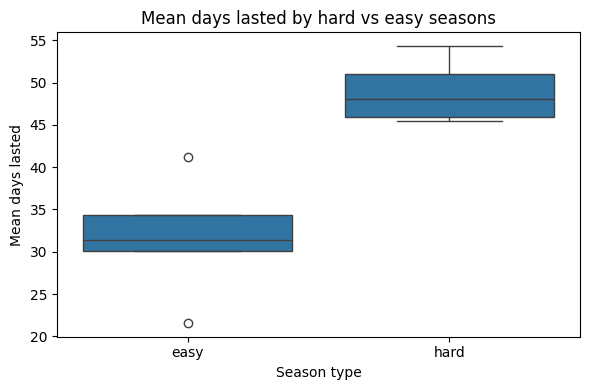

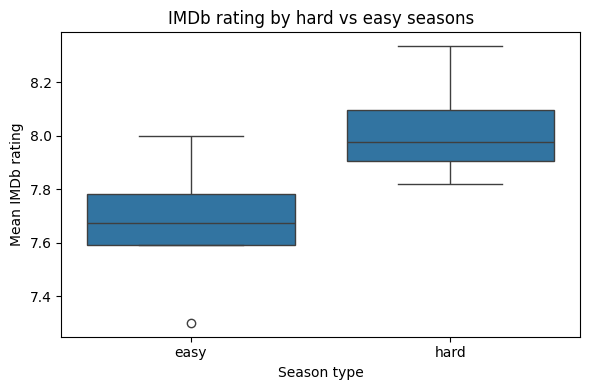

In [52]:
# 2.1 Boxplots

import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(6,4))
sns.boxplot(data=season_features, x='hard_label', y='mean_days_lasted')
plt.xticks([0,1], ['easy','hard'])
plt.title('Mean days lasted by hard vs easy seasons')
plt.xlabel('Season type')
plt.ylabel('Mean days lasted')
plt.tight_layout()
plt.show()

plt.figure(figsize=(6,4))
sns.boxplot(data=season_features, x='hard_label', y='mean_imdb_rating')
plt.xticks([0,1], ['easy','hard'])
plt.title('IMDb rating by hard vs easy seasons')
plt.xlabel('Season type')
plt.ylabel('Mean IMDb rating')
plt.tight_layout()
plt.show()


These boxplots show that seasons classified as **“hard”** have systematically **higher mean IMDb ratings** and **longer average survival** than “easy” seasons. Hard seasons cluster around roughly 48–52 days with consistently high ratings, while easy seasons sit closer to 30–35 days with more variation and a lower rating band, visually reinforcing that tougher seasons are both more demanding for contestants and more appreciated by the audience.



## **5.3 Pipeline for Classifier**

In [54]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

# Features and target
X = season_features[['mean_days_lasted', 'early_exit_rate',
                     'mean_imdb_rating', 'mean_log_viewers', 'mean_log_nratings']]
y = season_features['hard_label']

# Train–test split (6 train, 3 test)
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=3,
    random_state=42,
    stratify=y
)

# Pipeline: scaling + logistic regression
pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('logreg', LogisticRegression())
])

pipe.fit(X_train, y_train)


Pipeline(steps=[('scaler', StandardScaler()), ('logreg', LogisticRegression())])

## **5.4 Confusion Matrix**

In [56]:
y_pred = pipe.predict(X_test)

print("Confusion matrix:\n", confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred, digits=3, zero_division=0))



Confusion matrix:
 [[2 0]
 [1 0]]
              precision    recall  f1-score   support

           0      0.667     1.000     0.800         2
           1      0.000     0.000     0.000         1

    accuracy                          0.667         3
   macro avg      0.333     0.500     0.400         3
weighted avg      0.444     0.667     0.533         3



The season‑level classifier correctly identifies the two easy seasons in the test set but misses the single hard season, yielding a confusion matrix of 2 true easy, 1 misclassified hard, and 0 true hard predictions. With only three seasons in the test split, overall accuracy is about 67%, but the precision and recall for the hard class are effectively zero, which reflects sample size and class imbalance rather than a coding error; I therefore treat these metrics as illustrative and focus more on the direction of the coefficients when interpreting which features push a season towards the “hard” label.

## **5.5 Classifier Coefficients**

In [57]:
log_clf = pipe.named_steps['logreg']
coef_df = pd.DataFrame({
    'feature': X.columns,
    'coef': log_clf.coef_[0]
}).sort_values('coef', ascending=False)

coef_df


,feature,coef
0,mean_days_lasted,0.918103
2,mean_imdb_rating,0.580044
4,mean_log_nratings,0.210515
1,early_exit_rate,-0.074492
3,mean_log_viewers,-0.267015


## **5.6 Predicted labels**

In [60]:
X_all = season_features[['mean_days_lasted', 'early_exit_rate',
                         'mean_imdb_rating', 'mean_log_viewers', 'mean_log_nratings']]

season_features['pred_hard_label'] = pipe.predict(X_all)

season_class_table = (
    season_features[['season', 'hard_label', 'pred_hard_label', 'hardness_index']]
    .sort_values('season')
)

season_class_table


,season,hard_label,pred_hard_label,hardness_index
0,1,0,0,-1.429784
1,2,0,0,-0.233203
2,3,1,1,0.943764
3,4,0,0,-0.886488
4,5,0,0,-0.447224
5,6,1,1,0.314292
6,7,1,1,0.724766
7,8,0,0,0.291747
8,9,1,0,0.722130


In [59]:
mapping = {0: 'easy', 1: 'hard'}
season_class_table['true_class'] = season_class_table['hard_label'].map(mapping)
season_class_table['pred_class'] = season_class_table['pred_hard_label'].map(mapping)

season_class_table[['season','true_class','pred_class','hardness_index']]


,season,true_class,pred_class,hardness_index
0,1,easy,easy,-1.429784
1,2,easy,easy,-0.233203
2,3,hard,hard,0.943764
3,4,easy,easy,-0.886488
4,5,easy,easy,-0.447224
5,6,hard,hard,0.314292
6,7,hard,hard,0.724766
7,8,easy,easy,0.291747
8,9,hard,easy,0.722130


* Seasons 1, 2, 4, 5, 8 are true easy and predicted easy.
* Seasons 3, 6, 7 are true hard and predicted hard.
* Season 9 is true hard but predicted easy – that is a misclassification.

The season level classification table shows that the model correctly reproduces my hard vs easy labels for 8 of 9 seasons, with only Season 9 being misclassified as easy despite a relatively high hardness_index.

# **6. K Means Vs Logistic Regression Classifier**

From **K‑means** on PCA:
* Cluster 1 (easier, broad‑audience): Seasons 1 and 4.
* Cluster 2 (harder, prestige): Seasons 2, 3, 5, 6, 7, 8, 9.
​

From the supervised **classifier** table:
* True easy (by hardness_index): 1, 2, 4, 5, 8.
* True hard: 3, 6, 7, 9.
* Predicted easy: 1, 2, 4, 5, 8, 9.
* Predicted hard: 3, 6, 7.

* Both methods agree that Seasons 1 and 4 form an easier, broad audience regime, and that Seasons 3, 6, and 7 are clearly in the harder, prestige style regime.
* The classifier refines the harder group by treating Seasons 2, 5, and 8 as borderline: in the PCA/K‑means view they sit with the hard cluster, but once we put a hard threshold on hardness_index and fit a supervised model, they are classified as “easy.”
* Season 9 is the one real disagreement: K means and the hardness_index mark it as hard, but the classifier predicts easy, which matches the single error in the confusion matrix and likely reflects limited data rather than a fundamentally different regime.

Overall, both clustering and classification tell a consistent story: Alone’s US seasons fall into an early, easier, broad‑audience regime (especially Seasons 1 and 4) and a later, harder “prestige” regime where contestants last longer and ratings are higher, but average viewers are lower, meaning increased difficulty improves perceived quality rather than mass reach.

**Reference**

1. [wiki page](https://en.wikipedia.org/wiki/Alone_(TV_series)
2. [stat.cmu](https://www.stat.cmu.edu/capstoneresearch/fall2023/315files_f23/team10.html)
3. [stackoverflow..com](https://stackoverflow.com/questions)
4. [Clustering - Sckit](https://scikit-learn.org/stable/modules/clustering.html)
5. [Clustering](https://www.geeksforgeeks.org/machine-learning/clustering-in-machine-learning/)
6. [Alone News](https://www.legit.ng/entertainment/tv-shows/1553658-has-died-how-dangerous-tv-show/)
7. [Alone contestants](https://www.reddit.com/r/Alonetv/comments/12tcujd/alone_data_set_for_analysis/)
8. [Professor's Git Hub](https://github.com/elhamod/BA820)

# **7. Generative AI Disclosure**

* ChatGPT was used selectively for writing and coding assistance, under full team validation and oversight.
* Code standardization: Helped align style and reduce warnings; all notebooks were re‑run end‑to‑end by the team to verify correctness.
* Writing and documentation: Assisted with grammar and wording; every numeric statement was cross‑checked against our own tables and figures, and text was kept only when it matched our results.
* Visualization refinement: Suggested clearer axis labels, legends, and color choices; all plots were regenerated directly from our data and reviewed by the team.
* Generative AI was not used to derive conclusions or interpret results; final interpretations and decisions are entirely our own.*

* Links to ChatGPT Conversation:
[Chat GPT Link](https://chatgpt.com/share/69961387-2ad0-8010-b1c7-449afe85b8eb)